In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Storage dictionary for results
storage = {
    "adj_matrix": [],
    "laplacian_matrix": [],
    "delta": [],
    "data": [],
    "dist_matrix": [],
    "Fx": [],
    "Y_hub": [],
    "Y": [],
    "predicted_laplacian": []
}

# Output file
filename = f"../data/statistics_data/statistics_prl23.pkl"
f = open(filename, 'wb')

In [2]:
import numpy as np
import networkx as nx

# Load the .npz file
loaded = np.load('../data/generated_data.npz', allow_pickle=True)

# Extract data and structures
x = loaded['x']          # Time series (n, m, time)
A = loaded['A']          # Adjacency (n, n)
L = loaded['L']          # Laplacian (n, n)
delta = loaded['delta']  # Max degree (scalar)
k_in = loaded['k_in']    # In-degrees (n,)
G_adj = loaded['G']      # Adjacency from Graph (n, n)
G = nx.from_numpy_array(G_adj, create_using=nx.DiGraph)  # Reconstruct Graph with directed edges

# Extract parameters as dict
params = loaded['params'].item()  # .item() for dict
n = params['n']
m = params['m']
time = params['time']
transient = params['transient']
beta = params['beta']
mu = params['mu']
sigma = params['sigma']
C = params['C']
gamma = params['gamma']
eta = params['eta']

# Print for verification
print("Loaded data shape:", x.shape)
print("Loaded parameters:", params)
print("In-degrees shape:", k_in.shape)
print("Reconstructed Graph has", G.number_of_edges(), "edges")

Loaded data shape: (20, 2, 500)
Loaded parameters: {'n': 20, 'm': 2, 'time': 500, 'transient': 14000, 'beta': 4.1, 'mu': 0.001, 'sigma': 0.001, 'C': 0.1, 'gamma': 0.001, 'eta': 0.2}
In-degrees shape: (20,)
Reconstructed Graph has 24 edges


In [3]:
from scipy import sparse
from sklearn.linear_model import Lasso
import pysindy as ps
from pysindy.optimizers import BaseOptimizer

# Custom optimizer to use sklearn's Lasso with PySINDy
class LassoOptimizer(BaseOptimizer):
    def __init__(self, alpha=0.0001, fit_intercept=False, max_iter=100000, **kwargs):
        super().__init__(**kwargs)
        self.lasso = Lasso(alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter)

    def _reduce(self, x, y):
        self.lasso.fit(x, y)
        self.coef_ = self.lasso.coef_
        self.ind_ = np.abs(self.coef_) > 1e-10  # Threshold for non-zero coefficients
        return self

def data_split(n, x):
    X = x[:, :, :-1]  # x(t)
    dx = x[:, :, 1:]  # x(t+1)
    return X, dx

def predicted_models(n, X, dx, time):
    # Define custom library functions (SM Sec. VIII)
    library_functions = [
        lambda x: np.sin(x),
        lambda x: np.cos(x),
        lambda x: 1 / (1 - x),
        lambda x: 1 / (1 - x**2),
        lambda x: 1 / ((1 - x)**2),
        lambda x: 1 / (1 + x),
        lambda x: 1 / (1 + x**2),  # Critical for Rulkov
        lambda x: 1 / ((1 + x)**2),
        lambda x: 1 / x
    ]
    library_function_names = [
        lambda x: f'sin({x})',
        lambda x: f'cos({x})',
        lambda x: f'1/(1-{x})',
        lambda x: f'1/(1-{x}^2)',
        lambda x: f'1/(1-{x})^2',
        lambda x: f'1/(1+{x})',
        lambda x: f'1/(1+{x}^2)',
        lambda x: f'1/(1+{x})^2',
        lambda x: f'1/{x}'
    ]
    # Combine custom and polynomial libraries
    lib_custom = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
    lib_poly = ps.PolynomialLibrary(degree=1, include_bias=True, include_interaction=False)
    lib = ps.GeneralizedLibrary(
        [lib_custom, lib_poly],
        inputs_per_library=[[0, 0], [0, 1]]  # List to avoid warning
    )

    coeff = []
    t = np.arange(time - 1)  # Time array for discrete-time fitting
    for i in range(n):
        model = ps.SINDy(
            feature_library=lib,
            optimizer=LassoOptimizer(alpha=0.0001, fit_intercept=False, max_iter=100000),
            discrete_time=True
        )
        model.fit(X[i].T, t, x_dot=dx[i].T)  # Add time array t
        coeff.append(model.coefficients())
    return np.array(coeff)

# Split data
X, dx = data_split(n, x)
# Fit models
pred_models = predicted_models(n, X, dx, time)
print("Model coefficients shape:", pred_models.shape)  # Should be (n, m, num_features)

/Users/artun/Documents/GitHub/network-reconstruction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e-01, tolerance: 1.065e-01
  model = cd_fast.enet_coordinate_descent(


Model coefficients shape: (20, 2, 12)


In [6]:
from sklearn.metrics import pairwise_distances

def similarity(n, x, coeff, k_in):
    # Ground-truth correlation (for reference, not used in classification)
    corr_matrix_gt = np.corrcoef(x[:, 0, :], x[:, 0, :])[0:n, 0:n]
    # Distance matrix between model coefficients
    distance_matrix = pairwise_distances(coeff[:, 0, :], metric='seuclidean')
    # Row-sum histogram
    s = np.sum(distance_matrix, axis=1)
    s_gt = np.sum(np.abs(corr_matrix_gt), axis=1)
    hub_id = np.argmax(s)  # Hub: max distance (most different model)
    ld_id = np.argmin(s)   # Low-degree: min distance
    print(f"Predicted hub: {hub_id}, in-degree: {k_in[hub_id]}")
    print(f"Predicted low-degree node: {ld_id}, in-degree: {k_in[ld_id]}")
    return corr_matrix_gt, distance_matrix, s, s_gt, hub_id, ld_id

# Classify
corr_matrix_gt, distance_matrix, s, s_gt, hub_id, ld_id = similarity(n, x, pred_models, k_in)
storage["dist_matrix"].append(distance_matrix)

Predicted hub: 11, in-degree: 3.192561282077285
Predicted low-degree node: 14, in-degree: 0.0


In [7]:
def learn_local_dynamics(n, coeff, s):
    # Select low-degree nodes (e.g., bottom 50% of s)
    threshold = np.percentile(s, 50)
    low_degree_indices = np.where(s <= threshold)[0]
    # Average their coefficients
    f_coeff = np.mean(coeff[low_degree_indices], axis=0)
    return f_coeff

# Learn f
f_coeff = learn_local_dynamics(n, pred_models, s)
print("Local dynamics coefficients shape:", f_coeff.shape)

Local dynamics coefficients shape: (2, 12)


In [8]:
import numpy as np
import pysindy as ps

def local_dynamics_function(x, coeff, library):
    """
    Compute F_x by evaluating the SINDy library at x and applying coefficients.
    x: Input state, shape (m,) = (2,) for one node at one time.
    coeff: SINDy coefficients, shape (m, num_features) = (2, 12).
    library: SINDy GeneralizedLibrary object from predicted_models.
    Returns: Predicted next state, shape (m,) = (2,).
    """
    # Evaluate library functions at x
    # Reshape x to (1, m) for SINDy
    x_reshaped = x.reshape(1, -1)  # Shape (1, 2)
    features = library.fit_transform(x_reshaped)  # Shape (1, num_features)
    # Apply coefficients: features @ coeff.T
    # features: (1, num_features), coeff.T: (num_features, m)
    return np.dot(features, coeff.T).flatten()  # Shape (m,) = (2,)

def coupling_effect(dx, hub_id, Fx):
    """
    Compute coupling terms: Y_hub for hub node, Y for all nodes.
    dx: Node derivatives, shape (n, m, time-1).
    hub_id: Index of hub node.
    Fx: Predicted local dynamics, shape (n, m, time-1).
    Returns: Y_hub (m, time-1), Y (n, m, time-1).
    """
    Y_hub = dx[hub_id, :, :] - Fx[hub_id, :, :]
    Y = dx - Fx
    return Y_hub, Y

# Re-define the SINDy library (same as in predicted_models)
library_functions = [
    lambda x: np.sin(x),
    lambda x: np.cos(x),
    lambda x: 1 / (1 - x),
    lambda x: 1 / (1 - x**2),
    lambda x: 1 / ((1 - x)**2),
    lambda x: 1 / (1 + x),
    lambda x: 1 / (1 + x**2),
    lambda x: 1 / ((1 + x)**2),
    lambda x: 1 / x
]
library_function_names = [
    lambda x: f'sin({x})',
    lambda x: f'cos({x})',
    lambda x: f'1/(1-{x})',
    lambda x: f'1/(1-{x}^2)',
    lambda x: f'1/(1-{x})^2',
    lambda x: f'1/(1+{x})',
    lambda x: f'1/(1+{x}^2)',
    lambda x: f'1/(1+{x})^2',
    lambda x: f'1/{x}'
]
lib_custom = ps.CustomLibrary(library_functions=library_functions, function_names=library_function_names)
lib_poly = ps.PolynomialLibrary(degree=1, include_bias=True, include_interaction=False)
lib = ps.GeneralizedLibrary([lib_custom, lib_poly], inputs_per_library=np.array([[0, 0], [0, 1]]))

# Compute F_x for all nodes and times
Fx = np.zeros((n, m, time - 1))
for i in range(n):
    for t in range(time - 1):
        Fx[i, :, t] = local_dynamics_function(X[i, :, t], f_coeff, lib)

# Compute coupling effects
Y_hub, Y = coupling_effect(dx, hub_id, Fx)

# Store results
storage["Fx"].append(Fx)
storage["Y_hub"].append(Y_hub)
storage["Y"].append(Y)

# Verify shapes
print("Fx shape:", Fx.shape)  # Should be (n, m, time-1) = (20, 2, 499)
print("Y_hub shape:", Y_hub.shape)  # Should be (m, time-1) = (2, 499)
print("Y shape:", Y.shape)  # Should be (n, m, time-1) = (20, 2, 499)

/Users/artun/Documents/GitHub/network-reconstruction/.venv/lib/python3.13/site-packages/pysindy/feature_library/generalized_library.py:101: UserWarning: inputs_per_library should no longer be passed as a numpy array
  warn(


Fx shape: (20, 2, 499)
Y_hub shape: (2, 499)
Y shape: (20, 2, 499)


In [10]:
from sklearn.linear_model import Lasso
from pysindy.optimizers import BaseOptimizer
import numpy as np
import pysindy as ps
import pickle

# Custom Lasso optimizer for PySINDy
class LassoOptimizer(BaseOptimizer):
    def __init__(self, alpha=0.0001, fit_intercept=False, max_iter=100000, **kwargs):
        super().__init__(**kwargs)
        self.lasso = Lasso(alpha=alpha, fit_intercept=fit_intercept, max_iter=max_iter)

    def _reduce(self, x, y):
        self.lasso.fit(x, y)
        self.coef_ = self.lasso.coef_
        self.ind_ = np.abs(self.coef_) > 1e-10  # Threshold for non-zero coefficients
        return self

def reconstruction(n, m, time, X, Y):
    # Verify input shapes
    print("X shape:", X.shape)  # Expected: (n, m, time-1)
    print("Y shape:", Y.shape)  # Expected: (n, m, time-1)
    
    # Reshape for SINDy: (time-1, n*m)
    X_flat = X.reshape(n * m, time - 1).T  # (time-1, n*m)
    Y_flat = Y.reshape(n * m, time - 1).T  # (time-1, n*m)
    print("X_flat shape:", X_flat.shape)
    print("Y_flat shape:", Y_flat.shape)
    
    # Time array for discrete-time fitting
    t = np.arange(time - 1)
    print("t shape:", t.shape)  # Expected: (time-1,)
    
    # Initialize SINDy with custom Lasso optimizer
    model = ps.SINDy(
        feature_library=ps.IdentityLibrary(),
        optimizer=LassoOptimizer(alpha=0.001, fit_intercept=False),
        discrete_time=True
    )
    
    # Fit model with time array
    model.fit(X_flat, t=t, x_dot=Y_flat)
    
    # Get coefficients (n*m x n*m)
    L_pred = model.coefficients()
    print("L_pred raw shape:", L_pred.shape)
    
    # Extract n x n Laplacian (x-component coupling)
    xxx = np.arange(0, n * m, m)
    xx, yy = np.meshgrid(xxx, xxx)
    L_pred = L_pred[xx, yy]
    print("Extracted L_pred shape:", L_pred.shape)  # Should be (n, n)
    
    return L_pred

# Reconstruct Laplacian
L_pred = reconstruction(n, m, time, X, Y)
storage["predicted_laplacian"].append(L_pred)

# Save storage
pickle.dump(storage, f)
f.close()

X shape: (20, 2, 499)
Y shape: (20, 2, 499)
X_flat shape: (499, 40)
Y_flat shape: (499, 40)
t shape: (499,)
L_pred raw shape: (40, 40)
Extracted L_pred shape: (20, 20)


In [11]:
def rmse(L, L_pred, C, delta):
    # Ensure shapes match
    print("True L shape:", L.shape)
    print("Predicted L shape:", L_pred.shape)
    error = np.sqrt(np.mean((L - (C / delta) * L_pred)**2))
    return error

# Compute error
error = rmse(L, L_pred, C, delta)
print("RMSE:", error)

True L shape: (20, 20)
Predicted L shape: (20, 20)
RMSE: 0.40997282609853647


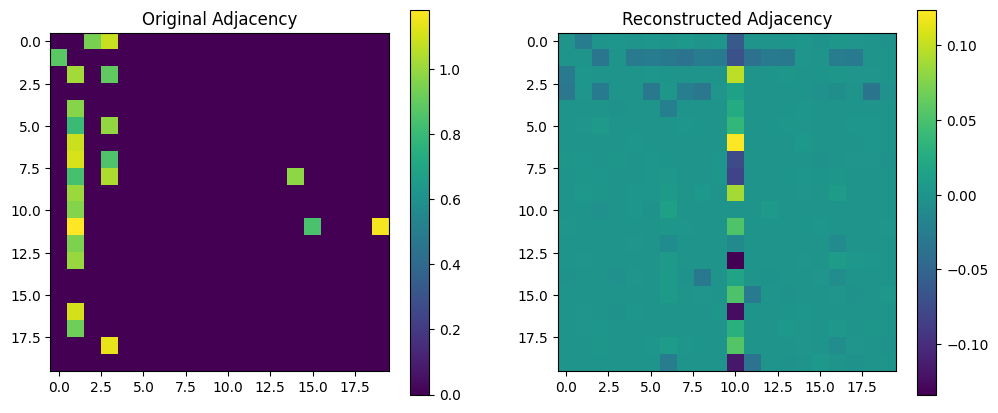

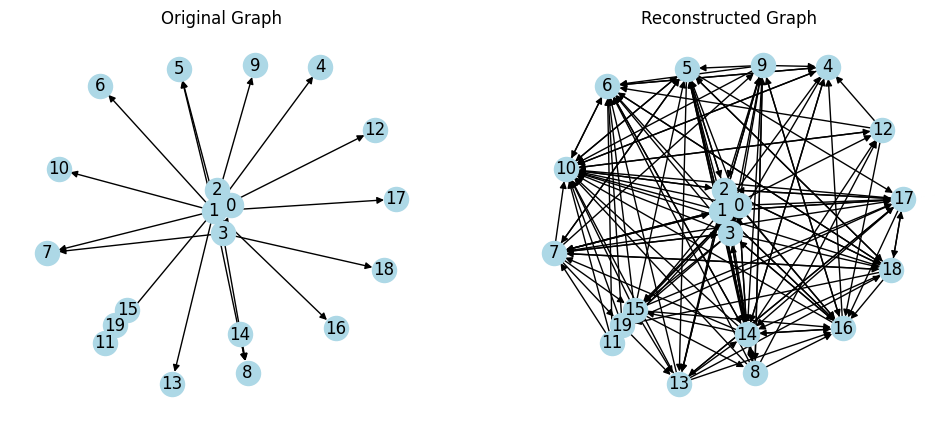

NameError: name 'dist_matrix' is not defined

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

# Plot Original and Reconstructed Networks
# Explanation: Visualizes the adjacency matrices and graph structures to compare the original network (A) with the reconstructed network (derived from L_pred). 
# The original adjacency (A) shows true connectivity, while -L_pred + diag(diag(L_pred)) approximates an adjacency-like matrix (off-diagonals as weights, diagonal adjusted).
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(A, cmap='viridis')
plt.title('Original Adjacency')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(-L_pred + np.diag(np.diag(L_pred)), cmap='viridis')  # Adjacency-like representation
plt.title('Reconstructed Adjacency')
plt.colorbar()
plt.show()

# Graph Visualization
# Explanation: Converts adjacency matrices to directed graphs using NetworkX. The spring_layout positions nodes consistently for comparison. 
# This helps visually assess if the reconstructed network retains the scale-free structure (few hubs, many low-degree nodes).
G_orig = nx.from_numpy_array(A.T, create_using=nx.DiGraph)
G_recon = nx.from_numpy_array(-L_pred + np.diag(np.diag(L_pred)).T, create_using=nx.DiGraph)
pos = nx.spring_layout(G_orig)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
nx.draw(G_orig, pos, with_labels=True, node_color='lightblue', arrows=True)
plt.title('Original Graph')
plt.subplot(1, 2, 2)
nx.draw(G_recon, pos, with_labels=True, node_color='lightblue', arrows=True)
plt.title('Reconstructed Graph')
plt.show()

# Identify hub and low-degree nodes using distance matrix
# Explanation: In the SINDy method, the distance matrix (dist_matrix) from model coefficient similarities is used to identify nodes. 
# The hub has the maximum row sum (most different model due to coupling), and the low-degree node has the minimum (least affected by coupling).
s_dist = np.sum(dist_matrix, axis=1)  # Sum of distances for each node
hub_id = np.argmax(s_dist)  # Node with maximum distance sum (hub)
ld_id = np.argmin(s_dist)   # Node with minimum distance sum (low-degree)
print(f"Hub ID (from distance): {hub_id}, Low-Degree ID: {ld_id}")

# Time Series Comparison
# Explanation: Plots the u-component time series for the first node (index 0) from both original and reconstructed data. 
# The dashed line for reconstructed data helps compare if the dynamics are preserved. Limiting to one node simplifies the plot for clarity.
plt.figure(figsize=(12, 6))
for i in range(1):  # Plot only the first node for simplicity
    plt.plot(x[i, 0, :], label=f'Orig Node {i}')
    plt.plot(x_reconstructed[i, 0, :], '--', label=f'Recon Node {i}')
plt.title('Time Series Comparison (Node 0)')
plt.xlabel('Time')
plt.ylabel('u-component')
plt.legend()
plt.show()

# Return Maps
# Explanation: Return maps plot u(t) vs. u(t+1) to visualize the chaotic attractor. 
# We compare low-degree and hub nodes for original vs. reconstructed data to check if the attractor structure is maintained. 
# Different colors (blue for original, red for reconstructed) distinguish the datasets.
u_orig = x[:, 0, :]  # u-component of original data
u_recon = x_reconstructed[:, 0, :]  # u-component of reconstructed data
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.scatter(u_orig[ld_id, :-1], u_orig[ld_id, 1:], s=1, c='blue', alpha=0.5)
plt.title(f'Orig Low-Deg ({ld_id}) Return Map')
plt.xlabel('u(t)')
plt.ylabel('u(t+1)')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.scatter(u_recon[ld_id, :-1], u_recon[ld_id, 1:], s=1, c='red', alpha=0.5)
plt.title(f'Recon Low-Deg ({ld_id}) Return Map')
plt.xlabel('u(t)')
plt.ylabel('u(t+1)')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.scatter(u_orig[hub_id, :-1], u_orig[hub_id, 1:], s=1, c='blue', alpha=0.5)
plt.title(f'Orig Hub ({hub_id}) Return Map')
plt.xlabel('u(t)')
plt.ylabel('u(t+1)')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.scatter(u_recon[hub_id, :-1], u_recon[hub_id, 1:], s=1, c='red', alpha=0.5)
plt.title(f'Recon Hub ({hub_id}) Return Map')
plt.xlabel('u(t)')
plt.ylabel('u(t+1)')
plt.grid(True)

plt.tight_layout()
plt.show()